In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(tidyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:gridExtra’:

    combine


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [33]:
%%R
workDir = '/home/chantal/Chazy/Chazy_SIP/data'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs'

# log2 fold change
l2fcResDir = '/home/chantal/Chazy/Chazy_SIP/data/'
l2fcResFile = file.path(l2fcResDir, 'l2fc_sparse-maxRejH.txt')

# physeq file
physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'SIP' 

# params
padj.cutoff = 0.1   # adjusted p-value cutoff for selecting incorporators
nprocs = 14

In [38]:
%%R 
F = file.path(physeqDir, physeqBulk)
physeq = readRDS(F)

physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 23458 taxa and 1038 samples ]
sample_data() Sample Data:       [ 1038 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 23458 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 23458 tips and 23457 internal nodes ]


## Filtering to water control samples

In [46]:
%%R
physeq.m = physeq %>% sample_data %>% as.matrix %>% as.data.frame
physeq.thresh.water = prune_samples(is.na(physeq.m$Treatment), physeq)
physeq.thresh.water = filter_taxa(physeq.thresh.water, function(x) sum(x) > 0, TRUE)
    
physeq.thresh.water

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1561 taxa and 41 samples ]
sample_data() Sample Data:       [ 41 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 1561 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1561 tips and 1560 internal nodes ]


In [48]:
%%R
mdf = psmelt(physeq.thresh.water)
head(mdf)

            OTU             Sample Abundance        Full.sample Fraction
41676    OTU.33 12C.PTH.D30.R2.H2O     15116 12C.PTH.D30.R2.H2O       NA
41668    OTU.33  12C.NTH.D3.R3.H2O      5988  12C.NTH.D3.R3.H2O       NA
32310 OTU.25553  13C.PTH.D7.R4.H2O      4443  13C.PTH.D7.R4.H2O        0
41664    OTU.33  13X.PTH.D3.R3.H2O      3728  13X.PTH.D3.R3.H2O       NA
20751    OTU.19  12C.NTH.D3.R3.H2O      3142  12C.NTH.D3.R3.H2O       NA
41681    OTU.33  13X.PTH.D3.R2.H2O      2898  13X.PTH.D3.R2.H2O       NA
      PrimerF PrimerR Barcode Rev.index Fwd.index Treatment Day Replicate Pool
41676    515f    806r      53  tagtctcc  tcatcgag      <NA>  NA        NA    9
41668    515f    806r     178  gtctatga  cgttacta      <NA>  NA        NA    7
32310    515f    806r      35  tgagtacg  tagcgagt      <NA>  NA        NA    4
41664    515f    806r     126  actcactg  tcgacgag      <NA>  NA        NA    7
20751    515f    806r     178  gtctatga  cgttacta      <NA>  NA        NA    7
41681    515f  

In [53]:
%%R
test = mdf %>% group_by(Sample) %>% summarise(seqcounts = sum(Abundance)) %>% arrange(-seqcounts) %>% head()
test

Source: local data frame [6 x 2]

              Sample seqcounts
               (chr)     (dbl)
1 12C.PTH.D30.R2.H2O     26952
2 12C.NTH.D30.R2.H2O     16130
3 13C.NTH.D14.R4.H2O     12069
4  12C.NTH.D3.R3.H2O     11743
5 13C.NTH.D30.R3.H2O     10379
6  13X.PTH.D3.R3.H2O      7746


In [59]:
%%R
test = filter(mdf, Sample %in% test$Sample & Abundance >100)

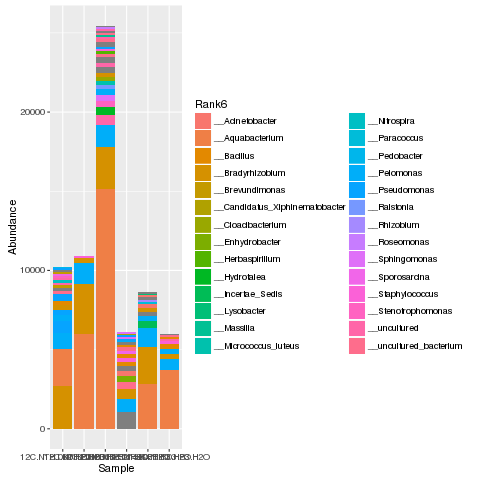

In [62]:
%%R
ggplot(test) + geom_bar(aes(x = Sample, y = Abundance, fill = Rank6), stat = 'identity')# + guides(fill = FALSE)

In [65]:
%%R
test %>% group_by(Rank3, Rank6) %>% summarise(sum = sum(Abundance)) %>% arrange(-sum) %>%as.data.frame

                   Rank3                          Rank6   sum
1  __Alphaproteobacteria               __Bradyrhizobium 12865
2  __Alphaproteobacteria                 __Sphingomonas   599
3  __Alphaproteobacteria                __Brevundimonas   292
4  __Alphaproteobacteria                   __Paracoccus   166
5  __Alphaproteobacteria                    __Rhizobium   144
6  __Alphaproteobacteria                   __uncultured   144
7  __Alphaproteobacteria                           <NA>   128
8  __Alphaproteobacteria                   __Roseomonas   108
9         __Anaerolineae                   __uncultured   213
10             __Bacilli                     __Bacillus  1428
11             __Bacilli               __Staphylococcus   684
12             __Bacilli               __Incertae_Sedis   436
13             __Bacilli                 __Sporosarcina   345
14  __Betaproteobacteria                __Aquabacterium 30000
15  __Betaproteobacteria                    __Pelomonas  7904
16  __Be

In [50]:
%%R
physeq.thresh.water.filt = filter_taxa(physeq.thresh.water, function(x) mean(x) > 0.001, TRUE)

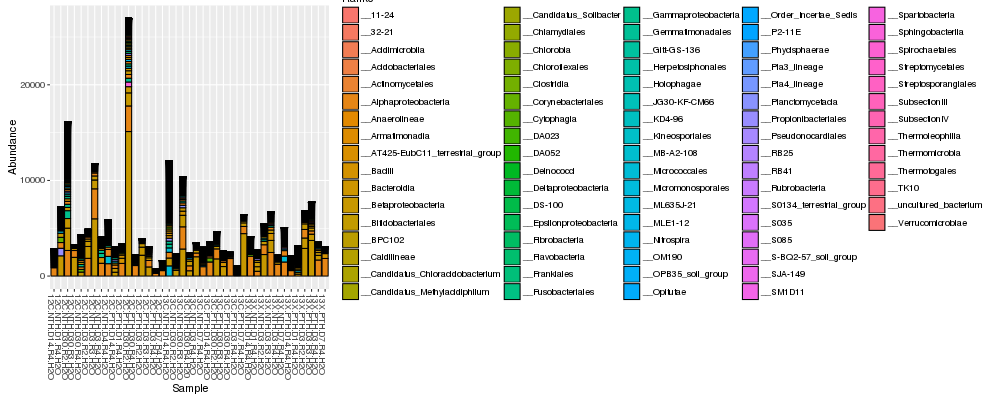

In [51]:
%%R -w 1000 -h 400
plot_bar(physeq.thresh.water.filt, fill='Rank3')

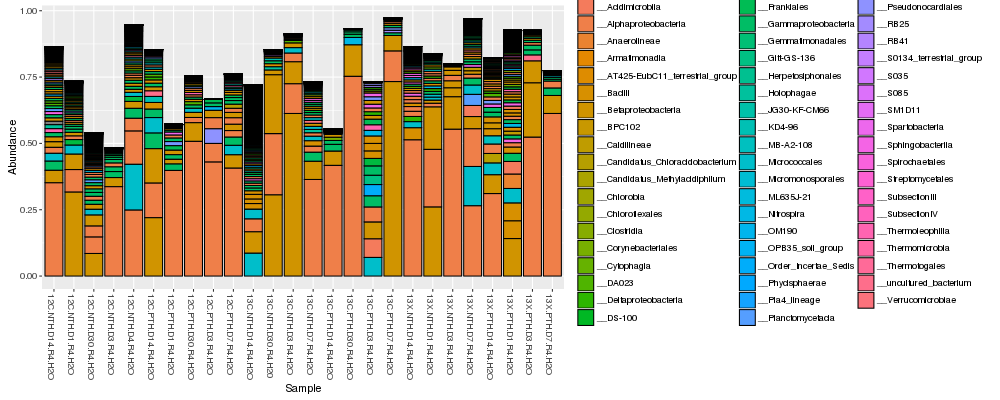

In [9]:
%%R -w 1000 -h 400
plot_bar(physeq.thresh.water, fill='Rank3')

In [10]:
%%R
physeq.thresh.w = physeq.thresh.water.filt %>% sample_data %>% as.matrix %>% as.data.frame

In [11]:
%%R
physeq.thresh.water.1 = prune_samples(physeq.thresh.w$Pool == 1, physeq.thresh.water.filt)
physeq.thresh.water.2 = prune_samples(physeq.thresh.w$Pool == 2, physeq.thresh.water.filt)
physeq.thresh.water.3 = prune_samples(physeq.thresh.w$Pool == 3, physeq.thresh.water.filt)
physeq.thresh.water.4 = prune_samples(physeq.thresh.w$Pool == 4, physeq.thresh.water.filt)

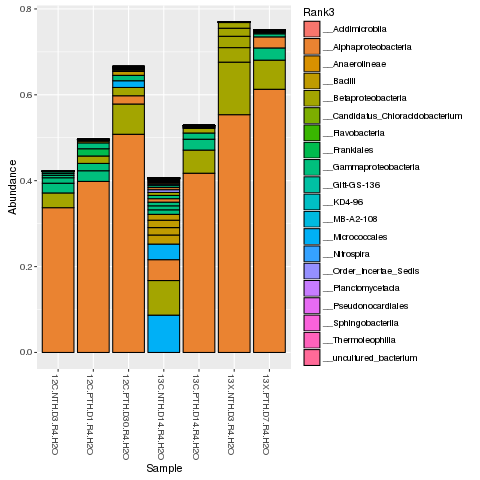

In [12]:
%%R
plot_bar(physeq.thresh.water.1, fill='Rank3')

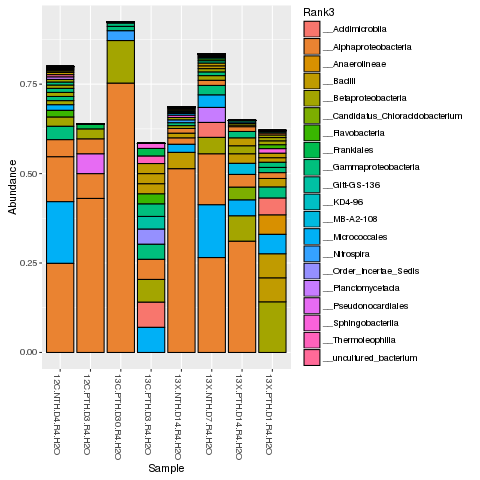

In [13]:
%%R
plot_bar(physeq.thresh.water.2, fill='Rank3')

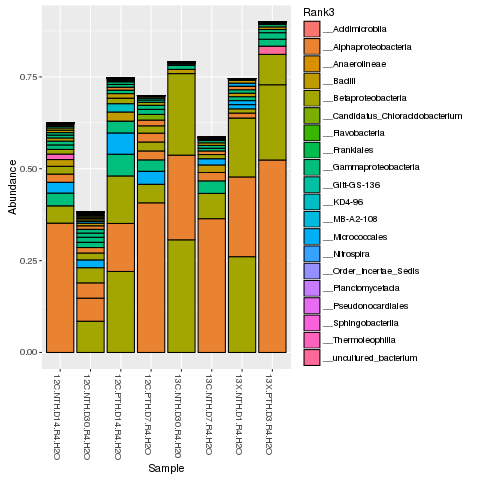

In [14]:
%%R
plot_bar(physeq.thresh.water.3, fill='Rank3')

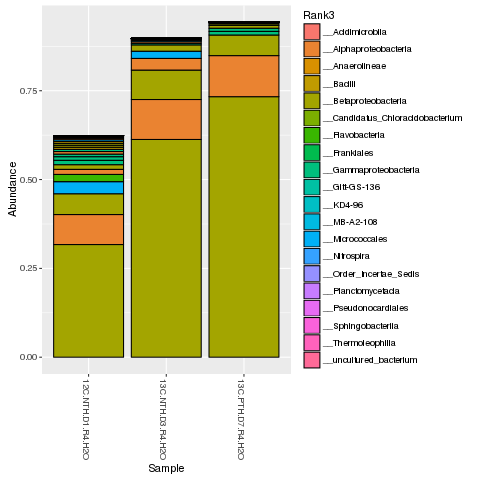

In [15]:
%%R
plot_bar(physeq.thresh.water.4, fill='Rank3')

In [16]:
%%R
df.water = psmelt(physeq.thresh.water.filt)

In [17]:
%%R
head(df.water)

       OTU             Sample Abundance        Full.sample Fraction PrimerF
702 OTU.30 13C.PTH.D30.R4.H2O 0.7530488 13C.PTH.D30.R4.H2O        0    515f
844 OTU.35  13C.PTH.D7.R4.H2O 0.7332926  13C.PTH.D7.R4.H2O        0     515
695 OTU.30  13X.PTH.D7.R4.H2O 0.6129769  13X.PTH.D7.R4.H2O        0    515f
839 OTU.35  13C.NTH.D3.R4.H2O 0.6127756  13C.NTH.D3.R4.H2O        0     515
688 OTU.30  13X.NTH.D3.R4.H2O 0.5537516  13X.NTH.D3.R4.H2O        0    515f
681 OTU.30  13X.PTH.D3.R4.H2O 0.5238498  13X.PTH.D3.R4.H2O        0    515f
    PrimerR Barcode Rev.index Fwd.index Treatment Day Microcosm.replicate Pool
702    806r     130  tgagtacg  cgttacta       H2O  NA                  NA    2
844     806      35  tgagtacg  tagcgagt       H2O  NA                  NA    4
695    806r     101  cgagagtt  acgtctcg       H2O  NA                  NA    1
839     806      61  cgagcgac  tcatcgag       H2O  NA                  NA    4
688    806r      50  tagtctcc  actatctg       H2O  NA                  NA

In [18]:
%%R
df.water$Rank2 = factor(df.water$Rank2, levels = df.water$Rank2[order(-df.water$Abundance)])
df.water$Rank3 = factor(df.water$Rank3, levels = df.water$Rank3[order(-df.water$Abundance)])
df.water$Rank4 = factor(df.water$Rank4, levels = df.water$Rank4[order(-df.water$Abundance)])
df.water$Rank5 = factor(df.water$Rank5, levels = df.water$Rank5[order(-df.water$Abundance)])



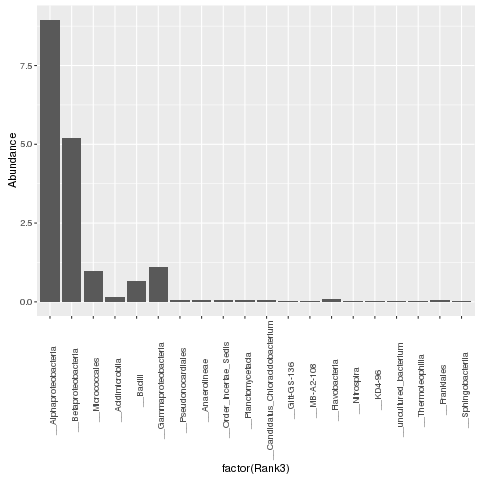

In [19]:
%%R
ggplot(df.water, aes(factor(Rank3), Abundance)) +
    geom_bar(stat = "identity") + theme(axis.text.x = element_text(angle = 90))

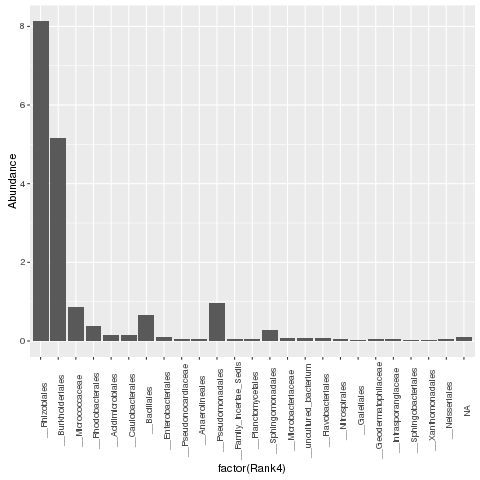

In [20]:
%%R
ggplot(df.water, aes(factor(Rank4), Abundance)) +
    geom_bar(stat = "identity") + theme(axis.text.x = element_text(angle = 90))

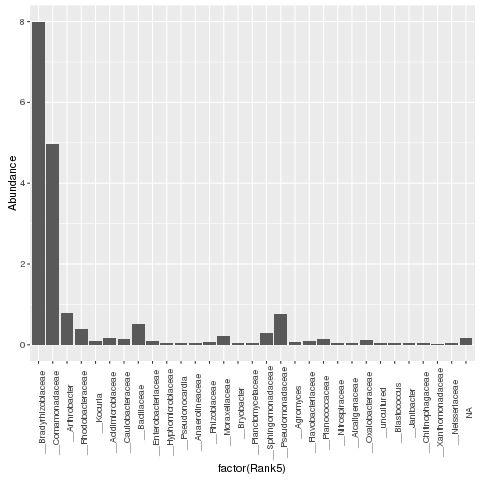

In [21]:
%%R
ggplot(df.water, aes(factor(Rank5), Abundance)) +
    geom_bar(stat = "identity") + theme(axis.text.x = element_text(angle = 90))

In [22]:
%%R
unique(df.water$Rank5)

 [1] __Bradyrhizobiaceae  __Comamonadaceae     __Arthrobacter      
 [4] __Rhodobacteraceae   __Kocuria            __Acidimicrobiaceae 
 [7] __Caulobacteraceae   __Bacillaceae        __Enterobacteriaceae
[10] __Hyphomicrobiaceae  __Pseudonocardia     __Anaerolineaceae   
[13] __Rhizobiaceae       __Moraxellaceae      __Bryobacter        
[16] __Planctomycetaceae  __Sphingomonadaceae  __Pseudomonadaceae  
[19] <NA>                 __Agromyces          __Flavobacteriaceae 
[22] __Planococcaceae     __Nitrospiraceae     __Alcaligenaceae    
[25] __Oxalobacteraceae   __uncultured         __Blastococcus      
[28] __Janibacter         __Chitinophagaceae   __Xanthomonadaceae  
[31] __Neisseriaceae     
30 Levels: __Bradyrhizobiaceae __Comamonadaceae ... __Neisseriaceae
